In [1]:
# import the libraries
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import polars as pl

import xgboost as xgb

In [2]:
# read the dataset
data = pl.read_csv("../data/pullreq_with_code.csv", truncate_ragged_lines=True).to_pandas()
data.head()

,id,project_id,github_id,pull_request_id,ownername,reponame,merged_or_not,lifetime_minutes,mergetime_minutes,num_commits,...,src_churn_open,test_churn_open,code_churn_open,churn_addition_open,churn_deletion_open,code_chunk_num_open,commits_on_files_touched_close,test_inclusion_open,added_code,
0,1,13708387,1895,16946031,stylelint,stylelint,1,237,237.0,1,...,0,0,0,0,0,1,79,0,"""eslint"": ""~3.5.0"",",None
1,3,93139005,404,42975776,binary-com,SmartCharts,1,4,4.0,1,...,0,0,0,0,0,1,175,0,"""version"": ""0.2.1"",",None
2,4,15059440,3434,34700062,letsencrypt,boulder,1,52,52.0,1,...,9,104,113,110,3,2,24,1,"\t\t} else if !strings.HasPrefix(name, ""*."") {...",None
3,5,29684214,486,34175163,PyCQA,astroid,1,2414,2414.0,1,...,33,27,60,60,0,2,7,1,\ndef numpy_core_numerictypes_transform():\n ...,None
4,6,79189935,379,37917551,compsy,vsv,1,91,91.0,1,...,26,0,26,11,15,3,13,0,"let!(:responses) { [some_response, another_r...",None


In [3]:
data['contrib_gender'].value_counts()

contrib_gender
male      54333
female     5873
Name: count, dtype: int64

In [4]:
# remove accepted requests and remove data where gender is unknown
rejected_data = data.loc[data['merged_or_not'] == 0]
rejected_data = rejected_data.loc[rejected_data['contrib_gender'].notna()]

In [5]:
rejected_data.shape

(8561, 142)

In [6]:
rejected_data['contrib_gender'].value_counts()

contrib_gender
male      7739
female     822
Name: count, dtype: int64

In [7]:
# drop columns that we do not need
rejected_data = rejected_data.drop(['ownername', 'reponame', 'id', 'project_id', 'github_id', 'creator_id'], axis=1)

In [8]:
# characteristics are from the paper (https://yuyue.github.io/res/paper/newPR_MSR2020.pdf)
# prepare characteristics to drop (contributor characteristics, project characteristics, are characteristics that the contributor cannot control)
contributor_characteristics = ['acc_commit_num', 'first_pr', 'core_member', 'same_country', 'same_affiliation', 'contrib_open', 'contrib_cons', 'contrib_extra', 'contrib_agree', 'contrib_neur', 'inte_open', 'inte_cons', 'inte_extra', 'inte_neur', 'inte_agree', 'open_diff', 'cons_diff', 'extra_diff', 'agree_diff', 'neur_diff', 'social_strength', 'account_creation_days', 'prior_review_num', 'first_response_time', 'contrib_country', 'inte_country', 'prior_interaction', 'contrib_affiliation', 'inte_affiliation', 'contrib_first_emo', 'inte_first_emo', 'contrib_follow_integrator']
project_characteristics = ['language', 'project_age', 'pushed_delta', 'pr_succ_rate', 'open_issue_num', 'open_pr_num', 'fork_num']
unable_to_control = ['followers', 'part_num_issue', 'part_num_commit', 'part_num_pr', 'pr_comment_num', 'num_issue_comments', 'has_comments', 'has_participants', 'inte_comment', 'has_exchange', 'num_comments_con', 'first_close_minutes', 'num_issue_comments', 'num_participants', 'lifetime_minutes', 'ci_exists',  'reviewer_comment', 'contrib_comment', 'contrib_rate_author'] # features that contributor cannot control

In [9]:
# drop unwanted characteristics
rejected_data.drop(contributor_characteristics, axis=1, inplace=True)
rejected_data.drop(project_characteristics, axis=1, inplace=True)
rejected_data.drop(unable_to_control, axis=1, inplace=True)
rejected_data.drop(['pull_request_id', 'first_closer_id', 'last_closer_id'], axis=1, inplace=True)

In [10]:
rejected_data.shape

(8561, 76)

In [11]:
# Assign smaller class (female) 1
gender_dict = {'male': 0, 'female': 1}

# Use the map function to replace the 'contrib_gender' column
rejected_data['contrib_gender'] = rejected_data['contrib_gender'].map(gender_dict)
df_majority = rejected_data[rejected_data['contrib_gender']==0]
df_minority = rejected_data[rejected_data['contrib_gender']==1]

df_majority_downsampled = df_majority.sample(len(df_minority), replace=False)

rejected_data = pd.concat([df_majority_downsampled, df_minority])
print(rejected_data['contrib_gender'].value_counts())

contrib_gender
0    822
1    822
Name: count, dtype: int64


In [12]:
rejected_data[rejected_data["contrib_gender"] == 0]

,merged_or_not,mergetime_minutes,num_commits,src_churn,test_churn,files_added,files_deleted,files_modified,files_changed,src_files,...,src_churn_open,test_churn_open,code_churn_open,churn_addition_open,churn_deletion_open,code_chunk_num_open,commits_on_files_touched_close,test_inclusion_open,added_code,
21394,0,NaN,1,0,0,0,0,1,1,0,...,0,0,0,0,0,1,1,0,<option{% if LANGUAGE_CODE == lang_cod...,513962.0
27183,0,NaN,1,108,0,0,0,2,2,1,...,108,0,108,57,51,4,9,0,"[//]: # ""To regenerate it, use `python -m synt...",850679.0
26796,0,NaN,5,50,76,0,0,4,4,2,...,37,42,79,77,2,8,30,1,2014-04-22\nGael Varoquaux\n\n ENH: Make me...,847988.0
56022,0,NaN,1,8,0,0,0,1,1,1,...,8,0,8,5,3,1,3,0,{post.children > 0 && (\n <sp...,2110420.0
14108,0,NaN,4,24,0,0,0,1,1,1,...,16,0,16,12,4,2,15,0,final argument in all cases. If `original` is ...,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60088,0,NaN,1,15,29,0,0,3,3,3,...,15,29,44,44,0,3,7,1,if (currentOptions.oneBasedIndex) ...,2202940.0
53219,0,NaN,1,0,0,0,0,1,1,0,...,0,0,0,0,0,1,16,0,"- CLIENT=""saucelabs:internet explorer:10:Win...",1923656.0
8344,0,NaN,1,38,20,0,0,30,30,29,...,38,20,58,29,29,30,3,0,* Copyright 2019 Google LLC,None
17509,0,NaN,4,103,0,0,0,10,10,6,...,5,0,5,4,1,1,8,0,"await onSubmit({ ...values, username: valu...",None


In [13]:
rejected_data[rejected_data["contrib_gender"] == 1]

,merged_or_not,mergetime_minutes,num_commits,src_churn,test_churn,files_added,files_deleted,files_modified,files_changed,src_files,...,src_churn_open,test_churn_open,code_churn_open,churn_addition_open,churn_deletion_open,code_chunk_num_open,commits_on_files_touched_close,test_inclusion_open,added_code,
53,0,NaN,3,65,0,0,0,1,1,1,...,65,0,65,38,27,3,5,0,"\t""lastUpdated"":""2016-05-12 13:25:00""\n ...",None
192,0,NaN,1,21,0,0,0,1,1,1,...,0,0,0,0,0,0,62,0,this.temperature = null;\n\tvar temper...,None
512,0,NaN,2,58,0,0,0,1,1,1,...,56,0,56,56,0,1,0,0,\n/**\n * Create a request\n *\n * @param {Re...,None
691,0,NaN,1,54,52,0,0,2,2,2,...,54,52,106,101,5,5,33,1,"@staticmethod\n def from_txt(filename, ...",None
729,0,NaN,1,0,0,1,0,0,1,0,...,0,0,0,0,0,1,0,0,this is a text !,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75529,0,NaN,59,6013,439,4,1,8,13,10,...,4398,263,4661,2613,2048,1,147,1,"""""""\n================================\nHierarc...",2833094.0
75695,0,NaN,1,16,0,0,0,7,7,7,...,16,0,16,8,8,8,5,0,private static readonly Uri InternetEx...,2833268.0
75723,0,NaN,4,32,0,0,0,1,1,1,...,32,0,32,26,6,2,5,0,"# :api, deprecated in 2.0.0, will be erase...",2833298.0
75740,0,NaN,1,2,0,0,0,1,1,1,...,2,0,2,1,1,1,0,0,"\t\t\t{fbvElement type=""textarea"" multilingual...",2833319.0


In [14]:
# encode all the columns that are not numerical, and save their label encoders
encoders = { }
for column in rejected_data.select_dtypes(include=['object']).columns:
    le_col = LabelEncoder()
    le_col.fit(rejected_data[column])
    rejected_data[column] = le_col.transform(rejected_data[column])
    encoders[column] = le_col

In [15]:
# find correlation to see which features are important
correlation_data = rejected_data.drop(['merged_or_not'], axis=1)

# Use Spearman's rank correlation coefficient instead of Pearson's
corr = correlation_data.corr(method='spearman')

correlation = corr['contrib_gender']
sorted([(k, v) for k, v in correlation.items() if k != 'contrib_gender' and v > 0], key=lambda x: x[1])

[('other_comment', 0.001438941273455801),
 ('test_inclusion_open', 0.0015728189962913816),
 ('last_close_time', 0.005121681371868183),
 ('test_inclusion', 0.006020465232267941),
 ('requester_succ_rate', 0.006785931159587667),
 ('num_code_comments', 0.009305023877053316),
 ('num_code_comments_con', 0.009631463567771219),
 ('integrator_availability', 0.013945492604836015),
 ('part_num_code', 0.014980858669452311),
 ('sloc', 0.01523329959438653),
 ('doc_files', 0.017867189038871446),
 ('doc_files_open', 0.018465056861095983),
 ('hash_tag', 0.021508447016262228),
 ('same_user', 0.023120532399260558),
 ('files_changed', 0.0259445003926087),
 ('files_deleted_open', 0.028993131733958864),
 ('added_code', 0.030234070029707925),
 ('files_changed_open', 0.030791583209714826),
 ('other_files', 0.033309400894339376),
 ('num_commits', 0.033837029462092404),
 ('num_commits_open', 0.040711495023337596),
 ('perc_external_contribs', 0.043737352276976),
 ('other_files_open', 0.043932251843527746),
 ('fi

In [16]:
threshold = 0.02 # moderate relationship or higher
high_correlation = list(filter(lambda x : x[1] >= threshold, sorted([(k, v) for k, v in correlation.items() if k != 'contrib_gender' and v > 0], key=lambda x: x[1])))
high_correlation_feat = list(map(lambda x : x[0], high_correlation))
print(high_correlation_feat)

['hash_tag', 'same_user', 'files_changed', 'files_deleted_open', 'added_code', 'files_changed_open', 'other_files', 'num_commits', 'num_commits_open', 'perc_external_contribs', 'other_files_open', 'files_deleted', 'files_added', 'files_added_open', 'team_size']


In [17]:
# get data and clean up data by removing n/a values
USE_CORRELATION = False

if USE_CORRELATION:
    features = high_correlation_feat
    print(features)
else:
    features = rejected_data.columns.tolist()
    # remove the target column
    toremove = ["contrib_gender", "added_code", "mergetime_minutes"]
    for i in toremove:
        features.remove(i)

# features = ['account_creation_days',  'contrib_open',  'part_num_issue',  'perc_neu_emotion',  'num_participants',  'perc_pos_emotion',  'ci_test_passed',  'asserts_per_kloc',  'followers',  'num_issue_comments',  'perc_neg_emotion',  'lifetime_minutes',  'test_inclusion',  'ci_exists',  'acc_commit_num',  'core_member',  'num_comments',  'at_tag',  'pushed_delta',  'part_num_commit',  'first_response_time',  'ci_latency',  'project_age',  'ci_build_num',  'first_pr',  'hash_tag',  'test_churn',  'num_commit_comments',  'comment_conflict',  'prev_pullreqs',  'bug_fix',  'churn_deletion',  'has_comments',  'has_participants',  'reviewer_comment',  'contrib_comment',  'inte_comment',  'has_exchange',  'same_country',  'perc_contrib_neu_emo',  'social_strength',  'agree_diff',  'contrib_rate_author',  'inte_open',  'contrib_follow_integrator',  'extra_diff',  'num_comments_con',  'first_close_minutes',  'perc_inte_pos_emo',  'neur_diff',  'perc_contrib_neg_emo',  'perc_inte_neu_emo',  'cons_diff',  'same_affiliation',  'test_inclusion_open',  'perc_inte_neg_emo',  'num_code_comments_con',  'friday_effect',  'test_churn_open',  'other_comment',  'perc_contrib_pos_emo',  'integrator_availability',  'churn_deletion_open']
rejected_data_cleaned = rejected_data[[*features, 'contrib_gender']].dropna()
X = rejected_data_cleaned[features]
y = rejected_data_cleaned['contrib_gender']

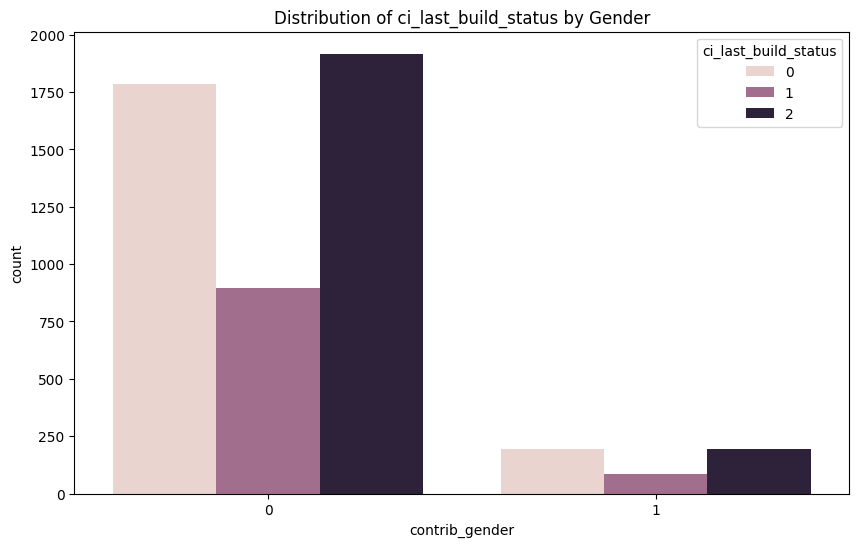

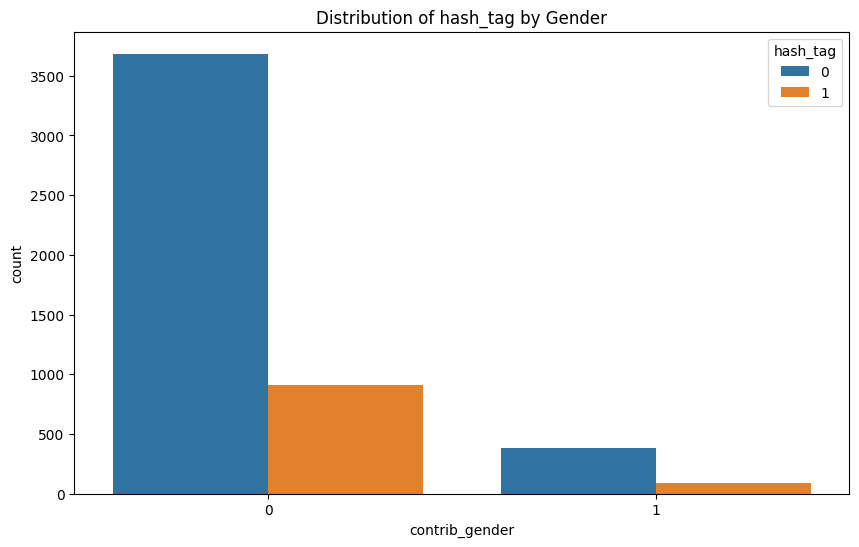

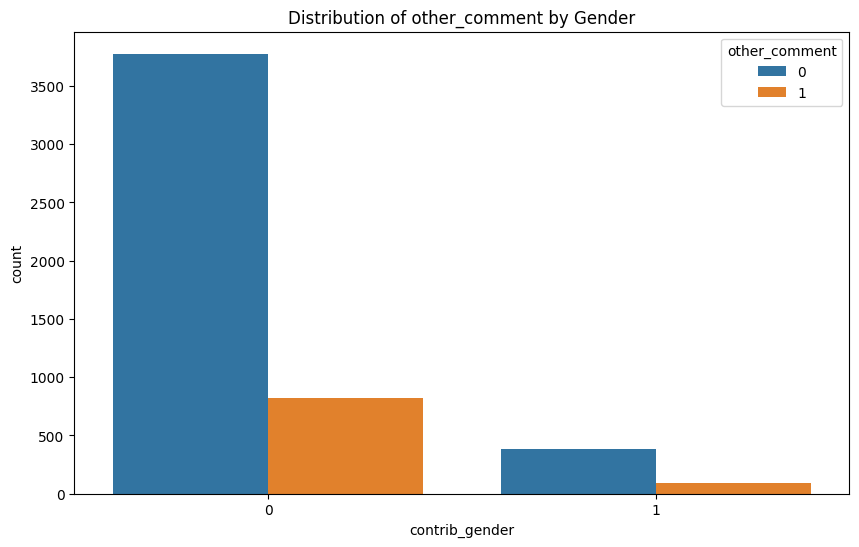

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
top_features = ['ci_last_build_status', 'hash_tag', 'other_comment']

for feature in top_features:
    plt.figure(figsize=(10, 6))
    sns.countplot(x="contrib_gender", hue=feature, data=rejected_data_cleaned)
    plt.title(f"Distribution of {feature} by Gender")
    plt.show()

In [18]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# split into train test val split
train_ratio = 0.70
test_ratio = 0.30

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1-train_ratio)

# Create a SMOTE object
smote = SMOTE()

# Fit the SMOTE object to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# train the XGBoost classifier model on the balanced training data
clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
clf = clf.fit(X_train_resampled, y_train_resampled)
clf.score(X_test, y_test)

/Users/thanosanp/miniconda3/envs/pytorch2/lib/python3.12/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


0.5763888888888888

Feature ranking:
1. feature perc_contrib_pos_emo (0.06963876634836197)
2. feature test_churn (0.03236696496605873)
3. feature other_comment (0.030218807980418205)
4. feature files_changed (0.027476739138364792)
5. feature perc_inte_neu_emo (0.0273977629840374)
6. feature num_code_comments (0.023732095956802368)
7. feature test_inclusion (0.023606780916452408)
8. feature perc_pos_emotion (0.022874992340803146)
9. feature code_churn_open (0.022457795217633247)
10. feature churn_deletion_open (0.022208089008927345)
11. feature files_added (0.022058846428990364)
12. feature test_churn_open (0.02081911824643612)
13. feature requester_succ_rate (0.020337935537099838)
14. feature perc_external_contribs (0.019904373213648796)
15. feature files_modified (0.019831711426377296)
16. feature src_churn (0.019197506830096245)
17. feature num_commits (0.01828070357441902)
18. feature team_size (0.01819555088877678)
19. feature ci_build_num (0.017712954431772232)
20. feature ci_last_build_status (0.017

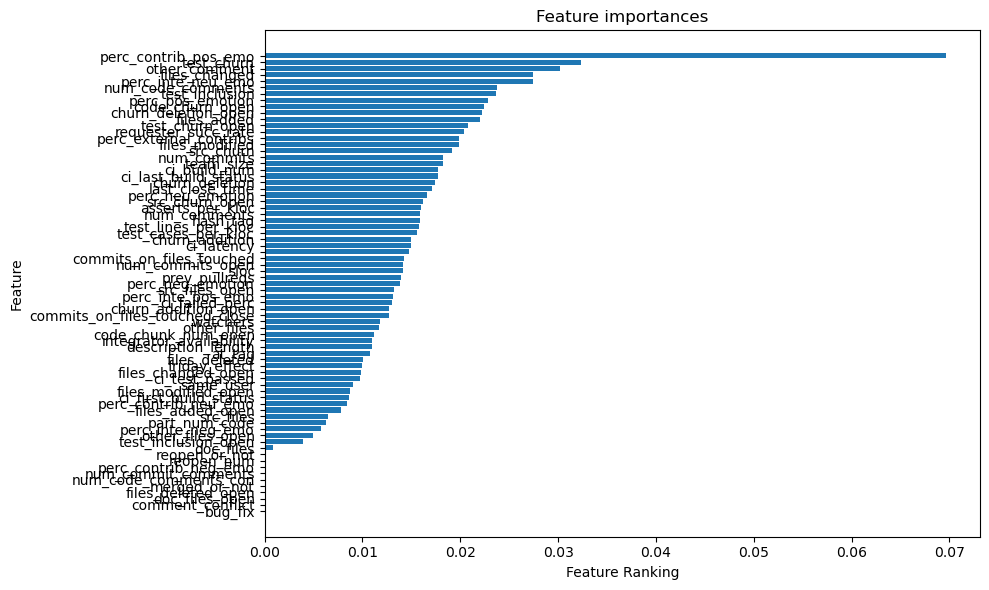

In [19]:
import matplotlib.pyplot as plt
# Get feature importances
importances = clf.feature_importances_

# Map importances to the corresponding feature names and sort them
feature_importances = sorted(zip(importances, X.columns), reverse=True)

# Print the feature ranking
print("Feature ranking:")

for rank, (importance, name) in enumerate(feature_importances, start=1):
    print(f"{rank}. feature {name} ({importance})")

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.barh([name for importance, name in feature_importances], [importance for importance, name in feature_importances])
plt.ylabel("Feature")
plt.xlabel("Feature Ranking")
plt.gca().invert_yaxis()  # invert the y-axis to have the most important feature at the top
plt.tight_layout()  # improve spacing
plt.show()

In [20]:
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_sample_weight

X_array = X.values
y_array = y.values

scale_pos_weight = y.value_counts()[0] / y.value_counts()[1]
clf = XGBClassifier(use_label_encoder=False, scale_pos_weight=scale_pos_weight, eval_metric='logloss')

kf = StratifiedKFold(n_splits=10, shuffle=True)

for train_index, test_index in kf.split(X_array, y_array):
    X_train, X_test = X_array[train_index], X_array[test_index]
    y_train, y_test = y_array[train_index], y_array[test_index]

    X_train, y_train = smote.fit_resample(X_train, y_train)

    clf.fit(X_train, y_train)
    
    predictions = clf.predict(X_test)
    
    print(classification_report(y_test, predictions, zero_division=0))

/Users/thanosanp/miniconda3/envs/pytorch2/lib/python3.12/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


              precision    recall  f1-score   support

           0       0.55      0.53      0.54        49
           1       0.53      0.55      0.54        47

    accuracy                           0.54        96
   macro avg       0.54      0.54      0.54        96
weighted avg       0.54      0.54      0.54        96

              precision    recall  f1-score   support

           0       0.55      0.55      0.55        49
           1       0.53      0.53      0.53        47

    accuracy                           0.54        96
   macro avg       0.54      0.54      0.54        96
weighted avg       0.54      0.54      0.54        96

              precision    recall  f1-score   support

           0       0.58      0.51      0.54        49
           1       0.55      0.62      0.58        47

    accuracy                           0.56        96
   macro avg       0.56      0.56      0.56        96
weighted avg       0.56      0.56      0.56        96

              preci